In [1]:
%matplotlib inline

In [2]:
from IPython.display import HTML

In [5]:
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import seaborn as sns
import tensorflow as tf
from theano import shared, tensor as tt

In [25]:
SEED = 69972 # from random.org, for reproducibility

np.random.seed(SEED)

In [13]:
blue, green, red, purple, gold, teal = sns.color_palette()

In [8]:
lidar_df = (pd.read_csv('./lidar.dat',
                        sep=' *', engine='python')
              .assign(std_range=lambda df: (df.range - df.range.mean()) / df.range.std(),
                      std_logratio=lambda df: (df.logratio - df.logratio.mean()) / df.logratio.std()))

/opt/conda/lib/python3.6/site-packages/pandas/io/parsers.py:1961: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/opt/conda/lib/python3.6/site-packages/pandas/io/parsers.py:1963: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [9]:
lidar_df[:5]

,range,logratio,std_logratio,std_range
0,390,-0.050356,0.852467,-1.717725
1,391,-0.060097,0.817981,-1.707299
2,393,-0.041901,0.882398,-1.686447
3,394,-0.050985,0.850240,-1.676020
4,396,-0.059913,0.818631,-1.655168


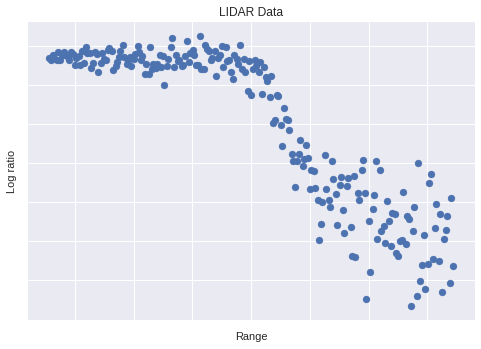

In [11]:
# plot the LIDAR dataset
fig, ax = plt.subplots()

ax.scatter(lidar_df.std_range, lidar_df.std_logratio, zorder=10);

ax.set_xticklabels([]);
ax.set_xlabel('Range');

ax.set_yticklabels([]);
ax.set_ylabel('Log ratio');

ax.set_title('LIDAR Data');


In [14]:
# fit and plot a few linear models on different intervals
# of the LIDAR data
LIDAR_KNOTS = np.array([-1.75, 0., 0.5, 1.75])

for left_knot, right_knot in zip(LIDAR_KNOTS[:-1], LIDAR_KNOTS[1:]):
    between_knots = lidar_df.std_range.between(left_knot, right_knot)
    slope, intercept, *_ = sp.stats.linregress(lidar_df.std_range[between_knots].values,
                                               lidar_df.std_logratio[between_knots].values)

    knot_plot_x = np.linspace(left_knot - 0.25, right_knot + 0.25, 100)
    ax.plot(knot_plot_x, intercept + slope * knot_plot_x, 
            c=red, lw=2, zorder=100);
    
ax.set_xlim(-2.1, 2.1);

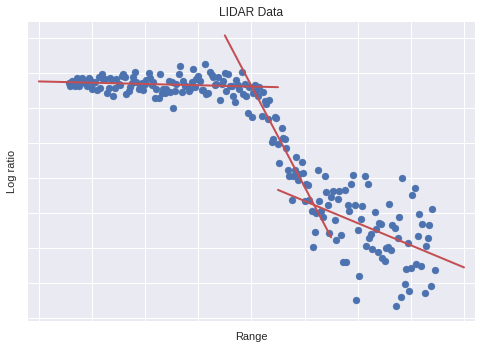

In [16]:
fig

In [17]:
std_range = lidar_df.std_range.values[:, np.newaxis]
std_logratio = lidar_df.std_logratio.values[:, np.newaxis]

In [19]:
def stick_breaking(v):
    """
    Perform a stick breaking transformation along
    the second axis of v
    """
    return v * tt.concatenate([tt.ones_like(v[:, :1]),
                               tt.extra_ops.cumprod(1 - v, axis=1)[:, :-1]],
                              axis=1)

In [20]:
K = 20

x_lidar = shared(std_range, broadcastable=(False, True))

with pm.Model() as lidar_model:
    alpha = pm.Normal('alpha', 0., 1., shape=K)
    beta = pm.Normal('beta', 0., 1., shape=K)
    
    v = tt.nnet.sigmoid(alpha + beta * x_lidar)
    pi = pm.Deterministic('pi', stick_breaking(v))

In [21]:
with lidar_model:
    gamma = pm.Normal('gamma', 0., 100., shape=K)
    delta = pm.Normal('delta', 0., 100., shape=K)
    tau = pm.Gamma('tau', 1., 1., shape=K)

    ys = pm.Deterministic('ys', gamma + delta * x_lidar)

In [22]:
def normal_mixture_rvs(*args, **kwargs):
    w = kwargs['w']
    mu = kwargs['mu']
    tau = kwargs['tau']
    
    size = kwargs['size']
    
    component = np.array([np.random.choice(w.shape[1], size=size, p=w_ / w_.sum())
                          for w_ in w])
    
    return sp.stats.norm.rvs(mu[np.arange(w.shape[0]), component], tau[component]**-0.5)

class NormalMixture(pm.distributions.Continuous):
    def __init__(self, w, mu, tau, *args, **kwargs):
        """
        w is a tesnor of mixture weights
        mu is a tensor of the means of the component normal distributions
        tau is a tensor of the precisions of the component normal distributions
        """
        super(NormalMixture, self).__init__(*args, **kwargs)
        
        self.w = w
        self.mu = mu
        self.tau = tau
        
        self.mean = (w * mu).sum()
    
    def random(self, point=None, size=None, repeat=None):
        """
        Draw a random sample from a normal mixture model
        """
        w, mu, tau = draw_values([self.w, self.mu, self.tau], point=point)
        
        return normal_mixture_rvs(w=w, mu=mu, tau=tau, size=size)
    
    def logp(self, value):
        """
        The log density of then normal mixture model
        """
        w = self.w
        mu = self.mu
        tau = self.tau
        
        return bound(logsumexp(tt.log(w) + (-tau * (value - mu)**2 + tt.log(tau / np.pi / 2.)) / 2.,
                               axis=1).sum(),
                     tau >=0, w >= 0, w <= 1)

In [23]:
with lidar_model:
    lidar_obs = NormalMixture('lidar_obs', pi, ys, tau,
                              observed=std_logratio)

In [26]:
%%time
N_ADVI_ITER = 50000

with lidar_model:
    advi_fit = pm.advi(n=N_ADVI_ITER, random_seed=SEED)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  after removing the cwd from sys.path.
Average ELBO = 1.8668e+05:  72%|███████▏  | 36049/50000 [00:23<00:08, 1551.32it/s] Median ELBO converged.
Finished [100%]: Average ELBO = 1.9711e+05


CPU times: user 26.7 s, sys: 970 ms, total: 27.7 s
Wall time: 1min 26s


In [30]:
PPC_SAMPLES = 5000

lidar_ppc_x = np.linspace(std_range.min() - 0.05,
                          std_range.max() + 0.05,
                          100)

with lidar_model:
    # sample from the variational posterior distribution
    advi_trace = pm.sample_vp(advi_fit, PPC_SAMPLES, random_seed=SEED)

    # sample from the posterior predictive distribution
    x_lidar.set_value(lidar_ppc_x[:, np.newaxis])
    advi_ppc_trace = pm.sample_ppc(advi_trace, PPC_SAMPLES, random_seed=SEED)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  if __name__ == '__main__':
  0%|          | 0/5000 [00:00<?, ?it/s]


MissingInputError: Undeclared input

NameError: name 'advi_ppc_trace' is not defined

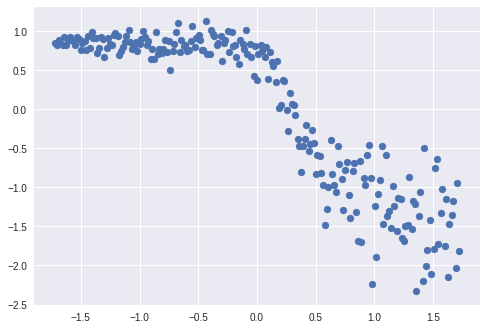

In [29]:
# plot the posterior predictions for the LIDAR data
fig, ax = plt.subplots()

ax.scatter(lidar_df.std_range, lidar_df.std_logratio,
           c=blue, zorder=10);

low, high = np.percentile(advi_ppc_trace['lidar_obs'], [2.5, 97.5], axis=0)
ax.fill_between(lidar_ppc_x, low, high, color='k', alpha=0.35, zorder=5);

ax.plot(lidar_ppc_x, advi_ppc_trace['lidar_obs'].mean(axis=0), c='k', zorder=6);

ax.set_xticklabels([]);
ax.set_xlabel('Range');

ax.set_yticklabels([]);
ax.set_ylabel('Log ratio');

ax.set_title('LIDAR Data');